# Subset ECG dataset

In [82]:
import os
import sys
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")
sys.path.append(os.getcwd()) 
import torch

from flower.task import Net, train
import glob
import torch
# import dataloader
from torch.utils.data import DataLoader
from lib.dataset_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from lib.physionet import PhysioNet, variable_time_collate_fn, get_data_min_max
from sklearn import model_selection
from torch.utils.data import DataLoader
from lib import utils
from lib.dataset_utils import store_dataset_physionet
import matplotlib.pyplot as plt
from lib.plot import plot_trajectories
from lib.plot_utils import read_loss_file, get_summary_lambdas, plot_client_loss
from matplotlib.lines import Line2D

path_prefix = "/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data"
prefix = "physionet"
batch_size = 64
classif = False
noise_weight = 0.1
max_t_extrap = 5
n_total_tp = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amp_start = 1.0
amp_end = 1.0 
freq_start =1.0
freq_end = freq_start
epochs = 5
batch_size = 3
sample_tp = 0.9
n_samples = 4
max_t_extrap = 50
lr_val = 0.01
cut_tp = None
extrap = None
rec_layers = 3
gen_layers = 3
units = 500
gru_units = 500
latents = 30
rec_dims = 40

from types import SimpleNamespace
args = SimpleNamespace()
args.sample_tp = 0
args.cut_tp = None
args.extrap = None


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
res_folders = ["ecg_physionet_level0_iid"]

In [84]:
path_prefix = "/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data"
prefix = "ecg_subset"

# for res_folder in res_folders:
#     print(f"Processing {res_folder}")
#     data_train_0 = torch.load(f"/Users/luisa/Desktop/nygc/data_test/{res_folder}/client_0_train.pt", weights_only=False)
#     data_test_0 = torch.load(f"/Users/luisa/Desktop/nygc/data_test/{res_folder}/client_0_test.pt", weights_only=False)
#     data_train_1 = torch.load(f"/Users/luisa/Desktop/nygc/data_test/{res_folder}/client_1_train.pt", weights_only=False)
#     data_test_1 = torch.load(f"/Users/luisa/Desktop/nygc/data_test/{res_folder}/client_1_test.pt", weights_only=False)
#     print(f"Loaded data for {res_folder}")
#     train_data_0 = data_train_0[:100]
#     test_data_0 = data_test_0[:20]
#     total_0 = train_data_0 + test_data_0
#     data_min_0, data_max_0 = get_data_min_max(total_0)
#     train_data_1 = data_train_1[:100]
#     test_data_1 = data_test_1[:20]
#     total_1 = train_data_1 + test_data_1
#     data_min_1, data_max_1 = get_data_min_max(total_1)

#     store_dataset_physionet(train_data_0, test_data_0, dataset_prefix=prefix, path_prefix=path_prefix, client_prefix=f"client_0")
#     store_dataset_physionet(train_data_1, test_data_1, dataset_prefix=prefix, path_prefix=path_prefix, client_prefix=f"client_1")
#     torch.save(data_min_0, f"{path_prefix}/{prefix}/client_0_data_min.pt")
#     torch.save(data_max_0, f"{path_prefix}/{prefix}/client_0_data_max.pt")
#     torch.save(data_min_1, f"{path_prefix}/{prefix}/client_1_data_min.pt")
#     torch.save(data_max_1, f"{path_prefix}/{prefix}/client_1_data_max.pt")

In [85]:
# Load dataset
dataset_name = "ecg_physionet_level0_iid"
c0 = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data/{prefix}/client_0_test.pt", weights_only=False)
#c1 = torch.load(f"/Users/luisa/Desktop/nygc/data_test/ecg_physionet_level0_iid/client_1_train.pt", weights_only=False)
# attr_names = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data/physionet_filtered/attr_names.pt", weights_only=False)
# attr_names_filtered = attr_names
# create list of string from 0 to 11


In [86]:
attr_names_filtered = np.array([f"var_{i}" for i in range(12)])
# load model weights 
model = Net()

# #model.load_state_dict(w_local)

In [87]:
w_cen = torch.load(f"/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin/model.pth",  map_location=torch.device('cpu'), weights_only=True)
# w_local = torch.load("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/results_physionet_filtered/physionet_filtered/local_training/client_0/10_epochs/10_epochs/lr_0.001-batchsize_64_clipping_False_lrdecay_1.0/model.pth",  map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(w_cen)

<All keys matched successfully>

Getting data min and max devices:  cpu


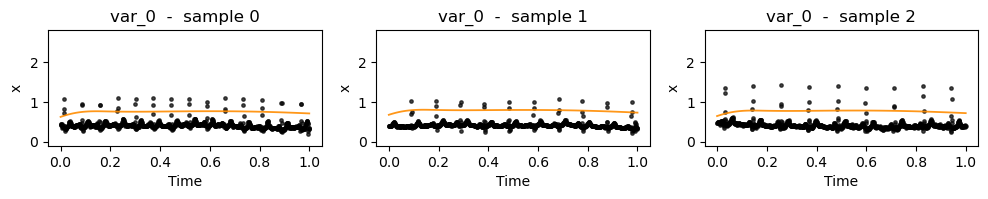

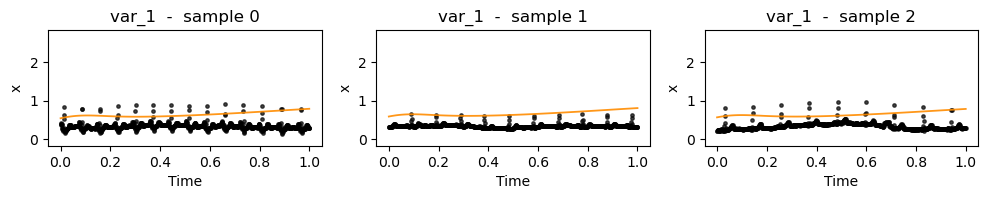

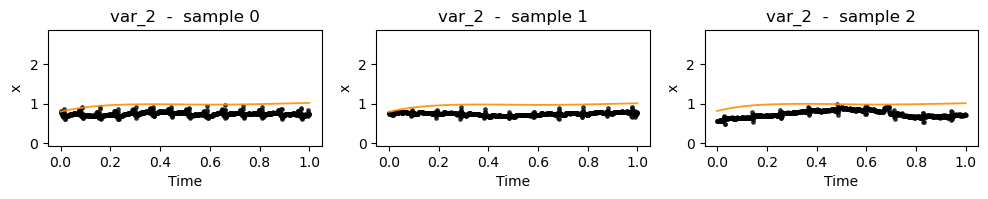

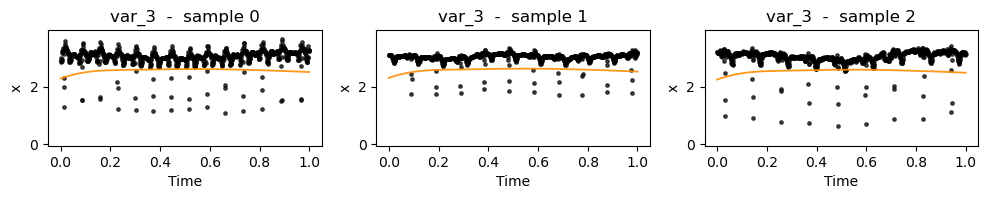

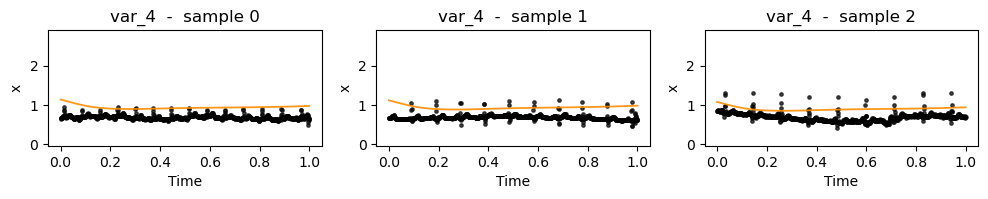

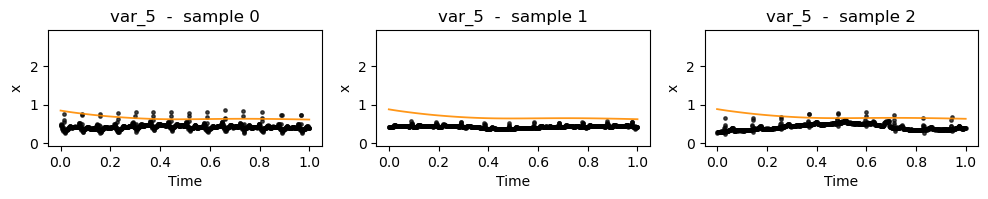

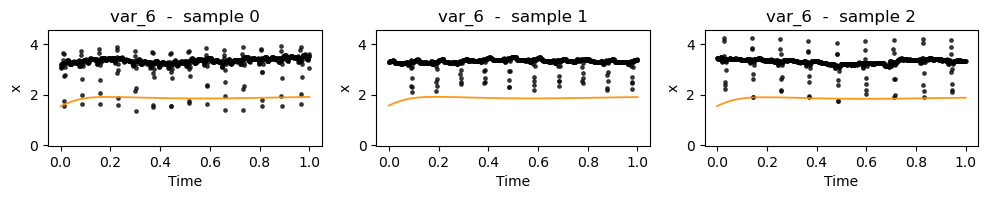

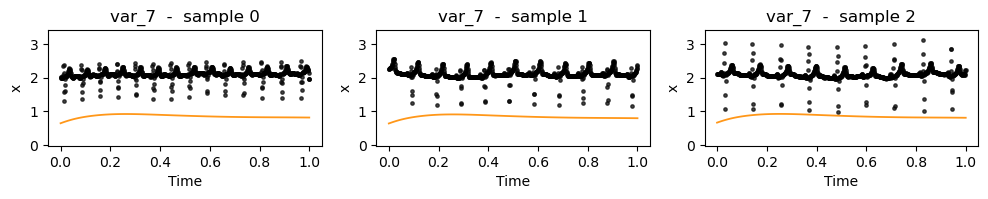

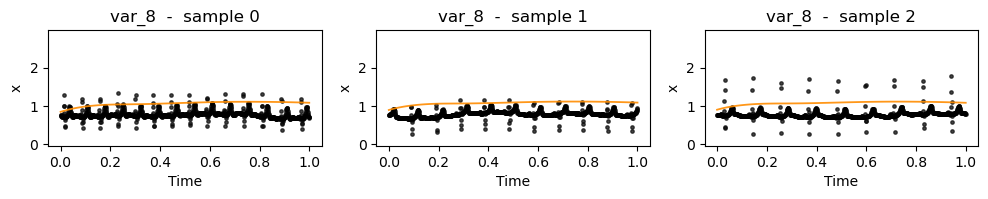

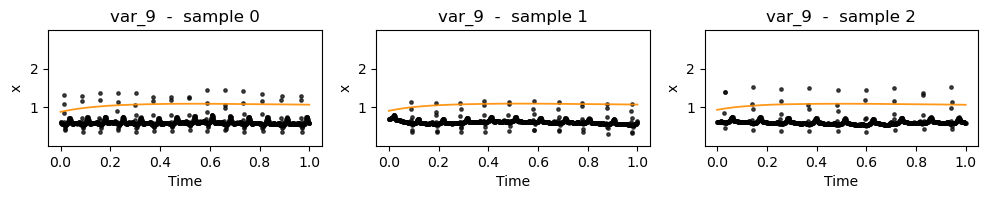

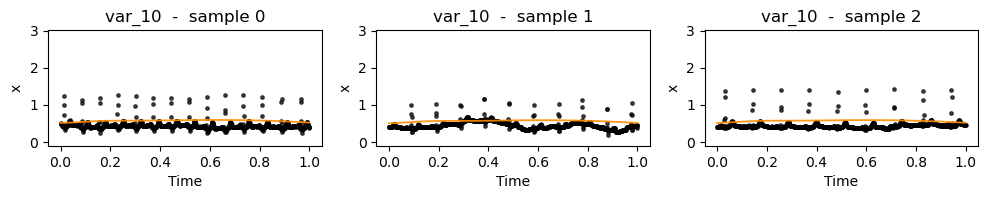

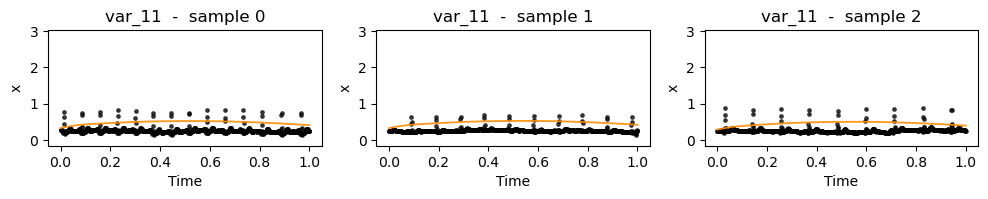

In [88]:


n_traj_to_show = 3
filtered_dataset = c0[1:10]
data_min, data_max = get_data_min_max(filtered_dataset)
testloader = DataLoader(filtered_dataset, batch_size= batch_size, shuffle=False,
    collate_fn= lambda batch: variable_time_collate_fn(batch, args, "cpu", data_type = "test",
        data_min = data_min, data_max = data_max))

testloader = utils.inf_generator(testloader)
test_dict = utils.get_next_batch(testloader)

# prepare dictionary in the format needed for prediction and plotting
data =  test_dict["data_to_predict"]
time_steps = test_dict["tp_to_predict"]
mask = test_dict["mask_predicted_data"]

observed_data =  test_dict["observed_data"]
observed_time_steps = test_dict["observed_tp"]
observed_mask = test_dict["observed_mask"]


time_steps_to_predict = time_steps
time_steps_to_predict = utils.linspace_vector(time_steps[0], time_steps[-1], 100).to(device)

with torch.no_grad():

    # Here use the model to obtain the predictions
    reconstructions, info = model.get_reconstruction(time_steps_to_predict, 
        observed_data, observed_time_steps, mask = observed_mask, n_traj_samples = 10)

    # plot only 10 trajectories
    data_for_plotting = observed_data[:n_traj_to_show]
    mask_for_plotting = observed_mask[:n_traj_to_show]

    data_full = data[:n_traj_to_show]

    reconstructions_for_plotting = reconstructions.mean(dim=0)[:n_traj_to_show]
    reconstr_std = reconstructions.std(dim=0)[:n_traj_to_show]

    for dim_to_show in range(attr_names_filtered.shape[0]):
        name = attr_names_filtered[dim_to_show]
        ax_traj = []
        fig, ax_traj = plt.subplots(1, n_traj_to_show)
        fig.set_size_inches(12, 1.5)
        max_y = max(
            data_for_plotting[:,:,dim_to_show].cpu().numpy().max(),
            reconstructions[:,:,dim_to_show].cpu().numpy().max())
        min_y = min(
            data_for_plotting[:,:,dim_to_show].cpu().numpy().min(),
            reconstructions[:,:,dim_to_show].cpu().numpy().min())
        
        cmap = plt.colormaps['Set1']
        for traj_id in range(n_traj_to_show):

            # Plot observations
            plot_trajectories(ax_traj[traj_id], 
                data_full[traj_id].unsqueeze(0), observed_time_steps, 
                mask = mask_for_plotting[traj_id].unsqueeze(0),
                min_y = min_y, max_y = max_y, #title="True trajectories", 
                marker = 'o', linestyle='', dim_to_show = dim_to_show, markersize= 2, alpha =0.9,
                color = "grey")
                    # Plot observations
            plot_trajectories(ax_traj[traj_id], 
                data_for_plotting[traj_id].unsqueeze(0), observed_time_steps, 
                mask = mask_for_plotting[traj_id].unsqueeze(0),
                min_y = min_y, max_y = max_y, #title="True trajectories", 
                marker = 'o', linestyle='', dim_to_show = dim_to_show, add_to_plot= True, markersize= 2.5, alpha =0.5,
                color = "black")
            
            # Plot reconstructions
            plot_trajectories(ax_traj[traj_id],
                reconstructions_for_plotting[traj_id].unsqueeze(0), time_steps_to_predict, 
                min_y = min_y, max_y = max_y, title="{}  -  sample {}".format(name, traj_id), dim_to_show = dim_to_show,
                add_to_plot = True, marker = '', color =  "darkorange", linewidth = 1.3, linestyle='-', alpha = 0.9)
            ax_traj[traj_id].set_ylim(min_y - 0.3, max_y+ 0.3)
    # print(min_y)
    
plt.show()

Getting data min and max devices:  cpu


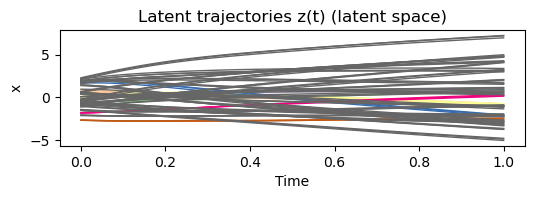

In [89]:
n_traj_to_show = 3
filtered_dataset = c0[10:40]
data_min, data_max = get_data_min_max(filtered_dataset)
testloader = DataLoader(filtered_dataset, batch_size= batch_size, shuffle=False,
    collate_fn= lambda batch: variable_time_collate_fn(batch, args, "cpu", data_type = "test",
        data_min = data_min, data_max = data_max))

testloader = utils.inf_generator(testloader)
test_dict = utils.get_next_batch(testloader)

# prepare dictionary in the format needed for prediction and plotting
data =  test_dict["data_to_predict"]
time_steps = test_dict["tp_to_predict"]
mask = test_dict["mask_predicted_data"]

observed_data =  test_dict["observed_data"]
observed_time_steps = test_dict["observed_tp"]
observed_mask = test_dict["observed_mask"]


time_steps_to_predict = time_steps
time_steps_to_predict = utils.linspace_vector(time_steps[0], time_steps[-1], 100).to(device)

with torch.no_grad():

    # Here use the model to obtain the predictions
    reconstructions, info = model.get_reconstruction(time_steps_to_predict, 
        observed_data, observed_time_steps, mask = observed_mask, n_traj_samples = 10)

    # plot only 10 trajectories
    data_for_plotting = observed_data[:n_traj_to_show]
    mask_for_plotting = observed_mask[:n_traj_to_show]

    data_full = data[:n_traj_to_show]

    reconstructions_for_plotting = reconstructions.mean(dim=0)[:n_traj_to_show]
    reconstr_std = reconstructions.std(dim=0)[:n_traj_to_show]

    # for dim_to_show in range(attr_names_filtered.shape[0]):
    #     name = attr_names_filtered[dim_to_show]
    ax_traj = []
    fig, ax_traj = plt.subplots(1, 1)
    fig.set_size_inches(6, 1.5)
    max_y = max(
        data_for_plotting[:,:,dim_to_show].cpu().numpy().max(),
        reconstructions[:,:,dim_to_show].cpu().numpy().max())
    min_y = min(
        data_for_plotting[:,:,dim_to_show].cpu().numpy().min(),
        reconstructions[:,:,dim_to_show].cpu().numpy().min())
    
    cmap = plt.colormaps['Set1']

    latent_traj = info["latent_traj"][0,:n_traj_to_show]
    # shape before permute: [1, n_tp, n_latent_dims]

    cmap = plt.colormaps['Accent']
    n_latent_dims = latent_traj.size(-1)

    custom_labels = {}
    for i in range(n_latent_dims):
        col = cmap(i)
        plot_trajectories(ax_traj, latent_traj, time_steps_to_predict, 
            title="Latent trajectories z(t) (latent space)", dim_to_show = i, color = col, 
            marker = '', add_to_plot = True,
            linewidth = 1)
            
            #custom_labels['dim ' + str(i)] = Line2D([0], [0], color=col)

        #ax_traj.set_ylabel("z")
        #ax_traj.set_title("Latent trajectories z(t) (latent space)", pad = 20)
        #ax_traj.legend(custom_labels.values(), custom_labels.keys(), loc = 'lower left')
plt.show()